# Import libraries and packages

In [1]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

# Load datasets

In [2]:
TRAIN_PATH = "Dataset/Train"
VAL_PATH = "Dataset/Val"

print(os.listdir("Dataset"))

['Prediction', 'Train', 'Val']


# Data Generators to prepare training and validation

In [4]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
test_dataset = image.ImageDataGenerator(rescale = 1./255)


In [5]:
train_generator = train_datagen.flow_from_directory(
    'Dataset/Train',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 288 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [7]:
validation_generator = test_dataset.flow_from_directory(
    'Dataset/Val',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 60 images belonging to 2 classes.


# Examples of images

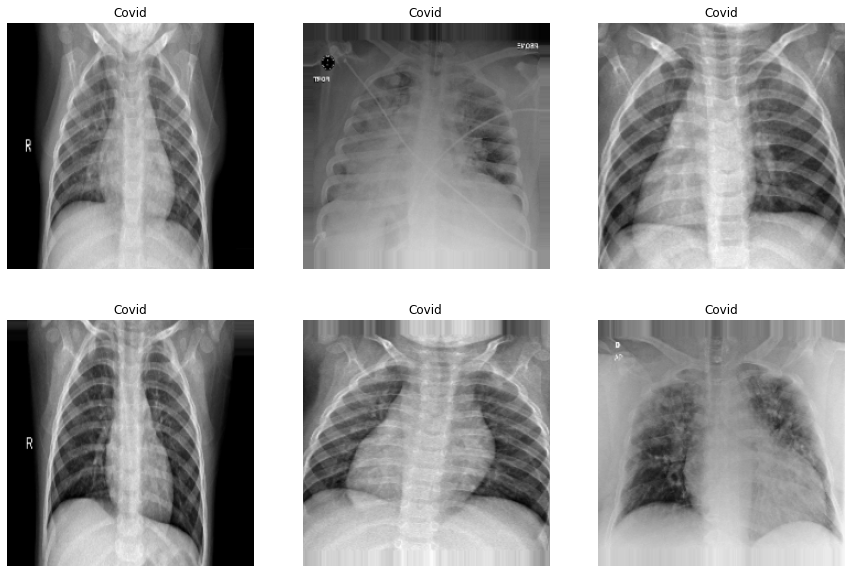

In [8]:
x,y = next(train_generator)
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# Load the model

In [ ]:
model = load_model("Detection_Covid_19_1.h5")

# Architecture model

In [9]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from os import listdir
from numpy.random import seed
from skimage import transform

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


LEARNING_RATE =0.0001

conv_base = Xception(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3)
                     )

conv_base.trainable = True

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', # for multiclass use categorical_crossentropy and for binary use BinaryCrossentropy
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['acc']
              )

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 46,552,105
Trainable params: 46,497,577
Non-trainable params: 54,528
_________________________________________________________________


# **Fit The Model**

In [11]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 2
)

C:\Users\Marcos Davi\AppData\Local\Temp\ipykernel_13476\430255416.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
8/8 [==============================] - 71s 8s/step - loss: 0.4488 - acc: 0.7852 - val_loss: 0.0678 - val_acc: 0.9667
Epoch 2/10
8/8 [==============================] - 68s 9s/step - loss: 0.1251 - acc: 0.9688 - val_loss: 0.0240 - val_acc: 0.9833
Epoch 3/10
8/8 [==============================] - 67s 8s/step - loss: 0.0345 - acc: 0.9922 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4/10
8/8 [==============================] - 67s 8s/step - loss: 0.0225 - acc: 0.9883 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 5/10
8/8 [==============================] - 67s 8s/step - loss: 0.0224 - acc: 0.9922 - val_loss: 5.7657e-04 - val_acc: 1.0000
Epoch 6/10
8/8 [==============================] - 66s 8s/step - loss: 0.0144 - acc: 0.9883 - val_loss: 5.7809e-05 - val_acc: 1.0000
Epoch 7/10
8/8 [==============================] - 67s 8s/step - loss: 0.0042 - acc: 1.0000 - val_loss: 3.7425e-05 - val_acc: 1.0000
Epoch 8/10
8/8 [==============================] - 67s 8s/step - loss: 0.0060 - acc: 0.9961 -

# Save the model

In [226]:
model.save("Detection_Covid_19_1.h5")

# Prepare results to create the confusion matrix

In [23]:
y_actual = []
y_test = []
train_generator.class_indices
history = hist
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [13]:
for i in os.listdir("./Dataset/Val/Normal"):
  img = keras.utils.load_img("./Dataset/Val/Normal/"+i,target_size=(224,224))
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  p = model.predict(img)
  y_test.append(p[0,0])
  y_actual.append(1)

1/1 [==============================] - 0s 91ms/step


In [14]:
for i in os.listdir("./Dataset/Val/Covid"):
  #img = image.load_img("./Dataset/Val/Covid/"+i,target_size=(224,224))
  img = keras.utils.load_img("./Dataset/Val/Covid/"+i,target_size=(224,224))
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  p = model.predict(img)
  y_test.append(p[0,0])
  y_actual.append(0)

1/1 [==============================] - 0s 79ms/step


In [16]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)
print(y_actual)
print(np.round(y_test))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
cm = confusion_matrix(y_actual,np.round(y_test))

In [19]:
import seaborn as sns

In [ ]:
# sns.heatmap(cm,cmap = "plasma" , annot=True)

# Prepare to plot confusion matrix

In [20]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
class_names = ["Covid-19","Normal"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="plasma"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[28  2]
 [ 7 23]]


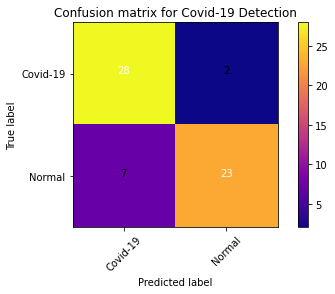

In [21]:
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix for Covid-19 Detection',cmap="plasma")


# **Summarize history for accuracy**

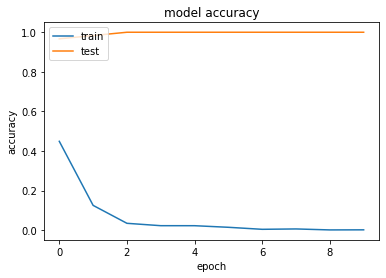

In [24]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# **Summarize history for loss**

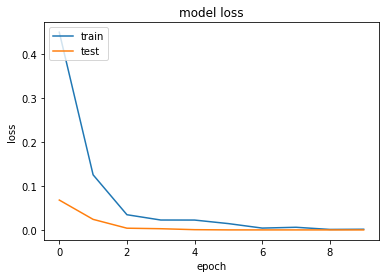

In [25]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Predictions from X-Ray Images**

1/1 [==============================] - 0s 84ms/step
This Xray Image is of positive covid-19 patient
Prediction Of Our Model :  Positive For Covid-19


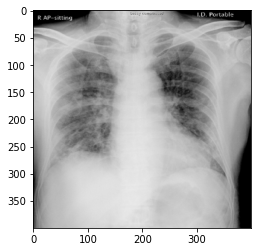

In [26]:
import numpy as np
# from google.colab.patches import cv2_imshow
import cv2
from keras.preprocessing import image
xtest_image = keras.utils.load_img('Dataset/Prediction/ryct.2020200034.fig5-day7.jpeg', target_size = (224, 224))
xtest_image = keras.utils.img_to_array(xtest_image)
xtest_image = np.expand_dims(xtest_image, axis = 0)
results = model.predict(xtest_image)
# training_set.class_indices
imggg = cv2.imread('Dataset/Prediction/ryct.2020200034.fig5-day7.jpeg')
print("This Xray Image is of positive covid-19 patient")
imggg = np.array(imggg)
imggg = cv2.resize(imggg,(400,400))
plt.imshow(imggg)
# cv2_imshow(imggg)
# print(results)
if results[0][0] == 0:
    prediction = 'Positive For Covid-19'
else:
    prediction = 'Negative for Covid-19'
print("Prediction Of Our Model : ",prediction)

1/1 [==============================] - 0s 97ms/step
This Xray Image is of Negative covid-19 patient
Prediction Of Our Model :  Negative for Covid-19


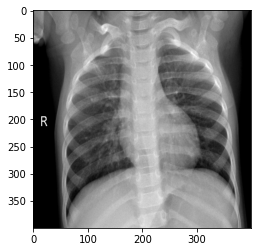

In [27]:
import numpy as np
# from google.colab.patches import cv2_imshow
from keras.preprocessing import image
xtest_image = keras.utils.load_img('Dataset/Prediction/NORMAL2-IM-0354-0001.jpeg', target_size = (224, 224))
xtest_image = keras.utils.img_to_array(xtest_image)
xtest_image = np.expand_dims(xtest_image, axis = 0)
results = model.predict(xtest_image)
# training_set.class_indices

imggg = cv2.imread('Dataset/Prediction/NORMAL2-IM-0354-0001.jpeg')
print("This Xray Image is of Negative covid-19 patient")
imggg = np.array(imggg)
imggg = cv2.resize(imggg,(400,400))

plt.imshow(imggg)
# cv2_imshow(imggg)
# print(results)
if results[0][0] == 0:
    prediction = 'Positive For Covid-19'
else:
    prediction = 'Negative for Covid-19'
print("Prediction Of Our Model : ",prediction)